In [329]:
import numpy as np
import pandas as pd
import umap
from scipy.sparse import dok_matrix
import glob
import numba
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
def get_w_f(path_to_counts):
    """
    Reads a counts file, returns types and frequencies
    """
    w, c = np.genfromtxt(path_to_counts,dtype=str).T
    c = c.astype(int)
    L = np.sum(c)
    if not isinstance(w,(list,np.ndarray)):
        w=[w]
        c=[c]
    return w, c/L


In [226]:
paths = glob.glob("../../gutenberg/data/counts/PG*")

In [227]:
# get full index

In [228]:
W = ! cat ../../gutenberg/data/counts/PG* | awk '{print $1}' | sort | uniq

In [306]:
d = 0
path = paths[0]
w, f = get_w_f(path)
M = dok_matrix((len(paths)+1,len(W)))

# initialize map from words to integers
w_idx = {v:k for k,v in dict(enumerate(W)).items()}

# add words to sparse matrix
for word,freq in zip(w, f):
    M[d,w_idx[word]] = freq
    
#n_diff_words = max(w_idx.values())

In [307]:
for d, path in enumerate(paths[1:],1):
    w, f = get_w_f(path)
    
    # add words to sparse matrix
    for word,freq in zip(w, f):
        M[d,w_idx[word]] = freq

In [263]:
import umap

In [296]:
u = umap.UMAP(metric=D_alpha_sparse_csr).fit_transform(MM)

In [330]:
languages_s = pd.read_table("../../gutenberg/.log", header=None).set_index(0)[1]
langs = languages_s.loc[ [path.split("/")[-1].split("_")[0] for path in paths] ].values
langs_dict = {v:k for k,v in dict(enumerate(set(langs))).items()}
colors = [ sns.color_palette("Set1",n_colors=len(set(langs)))[langs_dict[l]] for l in langs ]

/Users/fran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


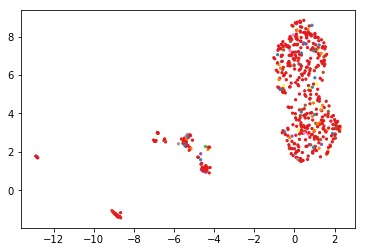

In [332]:
plt.scatter(*u.T, c=colors, s=5)

In [279]:
@numba.njit()
def D_alpha_max(H1,H2,pi1,pi2,alpha=1.0):
    '''The maximum Jensen-Shanon-divergence of two probability distributions p1 and p2
    with entropies H1 and H2 and weights pi1 and pi2.
    The maximum jsd is obtained by assuming the support of both distributions is disjunct.
    For more information see:
    Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
    https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    INPUT:
    - H1, float, alpha-entropy of p1
    - H2, float, alpha-entropy of p2
    - pi1, float, weight given to p1
    - pi2, float, weight given to p2
    optional
    - alpha, float (default:1.0)

    OUTPUT:
    - D_max, float - maximum JSD
    '''
    D_max = 0.0
    if alpha == 1.0:
        D_max = -pi1*np.log(pi1)-pi2*np.log(pi2)
    else:
        D_max = (pi1**alpha-pi1)*H1+\
                (pi2**alpha-pi2)*H2+\
                1.0/(1.0-alpha)*(pi1**alpha+pi2**alpha-1)
    return D_max

In [284]:
@numba.njit()
def H_alpha_sparse_csr(arr_p,alpha=1.0):
    '''Calculate generalized entropy of order-alpha
        H_{\alpha}(\vec{p}) = \frac{1}{1-\alpha}( \sum_i p_i^{\alpha} - 1  )
        https://en.wikipedia.org/wiki/Tsallis_entropy

        INPUT:
        - arr_p, array (normalized probability distribution)
        optional
        - alpha, float (default:1.0 == Boltzmann-Shannon-Gibbs entropy)
        OUT:
        - H_alpha, float

        Note that we have to consider special cases 
        - alpha=0; if p_i=0: p_i^0=0 and p_i>0: p_i^0=1  
        - alpha=1; H --> -\sum_i p_i log(p_i) and 0*log(0) = 0
    '''
    ## consider only entries with p>0
    arr_p_pos = arr_p
    H = 0.0
    if alpha == 0.0:
        H = len(arr_p_pos) - 1
    elif alpha == 1.0:
        H = -np.sum(arr_p_pos*np.log(arr_p_pos))
    else:
        H = 1.0/(1.0-alpha)*(np.sum(arr_p_pos**alpha) - 1.0)
    return H

In [285]:
def D_alpha_sparse_csr(arr_p1,arr_p2,alpha=1.0,pi1=0.5,normalized=False):
    '''
    Generalized Jensen-Shannon divergence proposed in:
        Gerlach, Font-Clos, Altmann, Phys. Rev. X 6 (2016) 021009
        https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.021009

    quantifying the divergence between probability distributions p1 and p2

    INPUT:
    - p1, array  
    - p2, array
    optional
    - alpha, float (default:1)
    - pi1, float (default:0.5); weight given to p1 (pi2 = 1-pi1)
    - normalized (default:False); if True return normalized version of alpha-JSD

    OUTPUT:
    - JSD, float

    Note that p1 and p2 have to be defined over the SAME support, i.e.
    for any index i the probabilities p1[i] and p2[i] refer to the same symbol.
    If, for example a symbol j only appears in p1, then p1[j]>0 and p2[j]=0 (and vice versa)
    '''

    pi2 = 1.0-pi1

    H_1 = H_alpha_sparse_csr(arr_p1.data,alpha=alpha)
    H_2 = H_alpha_sparse_csr(arr_p2.data,alpha=alpha)
    arr_p12 = pi1*arr_p1 + pi2*arr_p2
    H_12 = H_alpha_sparse_csr(arr_p12.data,alpha=alpha)

    D = H_12 - pi1*H_1 - pi2*H_2

    if normalized == False:
        norm = 1.0
    else:
        norm = D_alpha_max(H_1,H_2,pi1,pi2,alpha=alpha)
    D /= norm
    return D